In [ ]:
!pip install pandas numpy scikit-learn tensorflow matplotlib


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving asl_handmarks.csv to asl_handmarks.csv


In [ ]:
!ls -lh


total 6.3M
-rw-r--r-- 1 root root 6.3M Nov 30 23:18 asl_handmarks.csv
drwxr-xr-x 1 root root 4.0K Nov 20 14:30 sample_data


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load CSV, specifying no header and then renaming the first column to 'label'
df = pd.read_csv("asl_handmarks.csv", header=None)
df.rename(columns={0: 'label'}, inplace=True)

# Separate labels and features
X = df.drop("label", axis=1).values
y_text = df["label"].values

# Encode letter labels into numbers
le = LabelEncoder()
y = le.fit_transform(y_text)

num_classes = len(le.classes_)

print("Labels:", le.classes_)
print("Samples:", X.shape)

Labels: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
Samples: (5200, 63)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Build a tiny neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(63,)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])



model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.3f}")

Epoch 1/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0625 - loss: 3.1819 - val_accuracy: 0.1548 - val_loss: 2.5981
Epoch 2/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2400 - loss: 2.4188 - val_accuracy: 0.6269 - val_loss: 1.4395
Epoch 3/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4832 - loss: 1.5329 - val_accuracy: 0.7779 - val_loss: 0.8683
Epoch 4/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6261 - loss: 1.0773 - val_accuracy: 0.8865 - val_loss: 0.6044
Epoch 5/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7098 - loss: 0.8400 - val_accuracy: 0.9442 - val_loss: 0.4547
Epoch 6/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7702 - loss: 0.6771 - val_accuracy: 0.9471 - val_loss: 0.3402
Epoch 7/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8159 - loss: 0.5758 - val_accuracy: 0.9615 - val_loss: 0.2777
Epoch 8/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8543 - loss: 0.4855 - val_accuracy: 0.

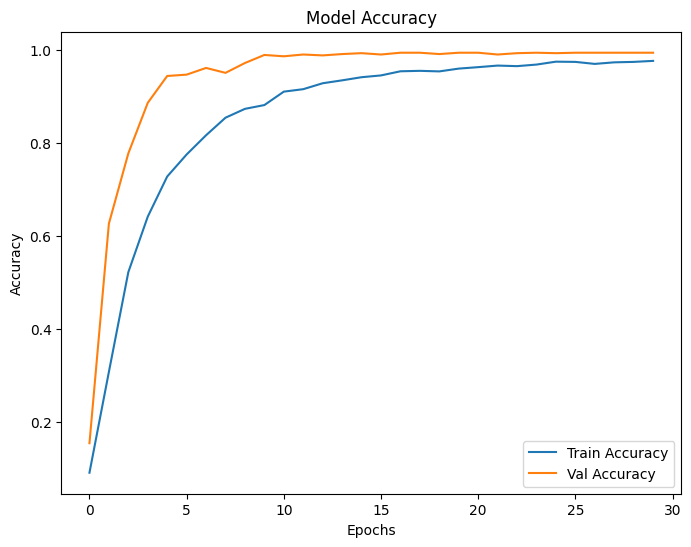

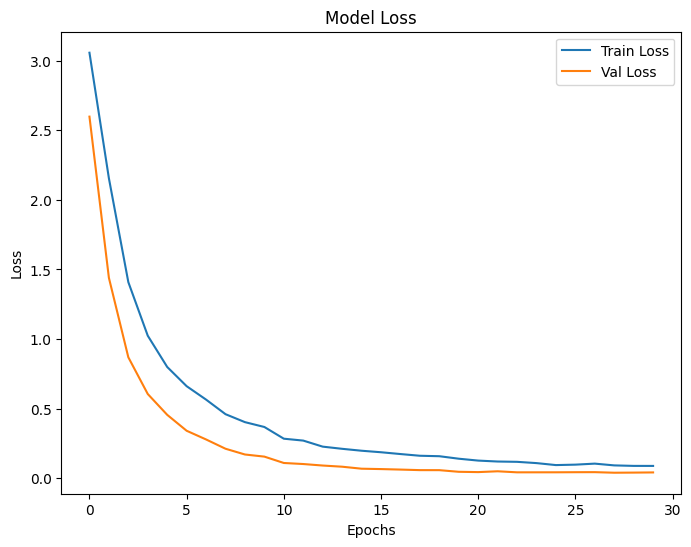

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf

# ------------------------------
# 1. Save label classes from existing LabelEncoder
# ------------------------------
np.save("label_classes.npy", le.classes_)
print("Saved label_classes.npy")

# ------------------------------
# 2. Convert Keras model → TFLite
# ------------------------------
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Use only builtin TFLite ops (safer for Pi runtime)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

# (Optional) don’t use optimizations for now
# converter.optimizations = []

tflite_model = converter.convert()

# ------------------------------
# 3. Save TFLite model
# ------------------------------
with open("asl_landmarks.tflite", "wb") as f:
    f.write(tflite_model)

print("🎉 Exported TFLite model and label files!")


In [ ]:
files.download("asl_landmarks.tflite")
files.download("label_classes.npy")


In [ ]:
import tensorflow as tf

# Load your TFLite model
interpreter = tf.lite.Interpreter(model_path="asl_landmarks.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("INPUT DETAILS:")
print(input_details)

print("\nOUTPUT DETAILS:")
print(output_details)
